# Importing Required Modules

In [1]:
#First import the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import rasterio
from scipy import stats
from sklearn.cluster import *

# Accessing All the image files using glob

In [7]:
#First I obtain all the images available in the data folder
ImgList = glob.glob('C:/Users/marxd/Desktop/GEO1001_ST/2020/iceland/S2A_MSIL1C_20190820T125301_N0208_R138_T27WXN_20190820T162259/GRANULE/L1C_T27WXN_A021728_20190820T125315/IMG_DATA/resampled60m/*.jp2')
#Now I check for the files present in our ImgList
for i in ImgList:
    print(i)
#print(ImgList[0].split('_'))

In [8]:
ImgList

[]

In [6]:
#For some reason, bands like WHL and SCL were not present after downloading 0% cloud cover data from the Coperincus Portal. Although bands B01 and B09 were in 60m resolution, the rest were in 20m resolultion and were resampled using FME and QGIS.

# Checking Metadata

In [7]:
#Check raster metadata to make sure everything is in order
for i in range(len(ImgList)):
    x=rasterio.open(ImgList[i])
    print(x.meta)

# Preprocessing of data

In [8]:
#Convert data to a dictionary for further use
#Collecting bands and creating raster data for dictionary
bands=[]
rasterData=[]
for i in ImgList:
    bands.append(i.split('_')[3])
    rasterData.append(rasterio.open(i))
#Now using the above two lists, a dictionary is created. Order is preserved in standard dictionaries
dataR60m={bands[i]: rasterData[i] for i in range(len(bands))} 

# Visual Inspection

In [9]:
#As all of the required data is available let's check the greyscale plots
data=list(dataR60m.values())
fig = plt.figure(figsize=(30,30))
for i in range(len(bands)):
    A=plt.subplot2grid((7,2),(i//2,i%2))
    A.imshow(data[i].read()[0],cmap='gray')
    A.set_title(bands[i])
plt.show()

<Figure size 2160x2160 with 0 Axes>

Making a true color image using red, green and blue bands    

In [21]:
#Let's make the plot more colorful, by combining red, blue, green
band=['B02','B03, B04']
#taking data for the specific bands
dataRGB=[]
for i in band:
    dataRGB.append(dataR60m[i])
#Now let's stack the images on each other
stack_list=[]
for i in dataRGB:
    stack_list.append(i.read()[0].flatten()/3000)
stack=np.array(stack_list).T
rgb_arr = np.array(np.split(stack, dataRGB[0].width))
fig = plt.figure(figsize=(10,10))
plt.axis('off')
plt.imshow(rgb_arr)

KeyError: 'B02'

# Function Definitions

In [5]:
#I will need data to create stacks, so I made a function for that
def createData(raster_dict,bands):
    data=[]
    for i in bands:
        data.append(raster_dict[i])
    return data
#Since I will need to stack the bands together, it is useful to define a stacking function
def data2stack(data):
    array_1D=[]
    for i in data:
        array_1D.append(i.read()[0].flatten())
    stack=np.array(array_1D).T
    return stack



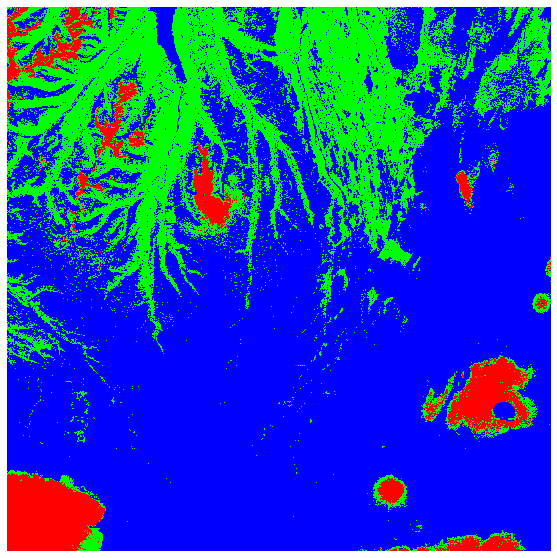

In [21]:
#Now I can try the K-means algorithm
#From inspection it can be seen that 3 classes might be good 
n_classes=3
data=createData(dataR60m,bands)
stack = data2stack(data)
kmeans = KMeans(n_clusters=n_classes).fit(stack)

label_array = np.array(np.split(kmeans.labels_, data[0].width))

plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(label_array, cmap='brg', interpolation='nearest')


Glacier shows up as red, tundra as green and blue as a mix of water and flood plain with three classes.

In [ ]:
#Checking the number of occurences

In [22]:
for i in range(n_classes):
  print('Label', i, ' : ',np.count_nonzero(kmeans.labels_ == i),  'occurences')

Label 0  :  2344074 occurences
Label 1  :  188161 occurences
Label 2  :  816665 occurences


Creating scatter plot for the clusters

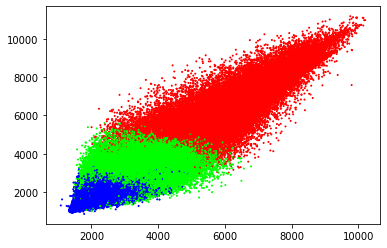

In [23]:
plt.scatter(stack.T[0], stack.T[1], c=kmeans.labels_, cmap='brg', s=1, alpha=1)

# Determination of optimal number of clusters using elbow method

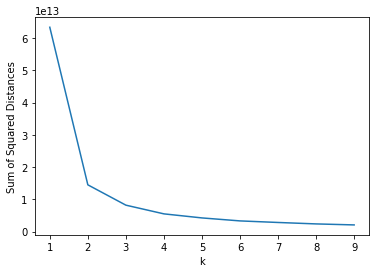

In [7]:
#Before determining the optimal number of bands to use, let's determine optimal number of classes
sum_of_SDs=[]
#let's assume maximum number of classes can be 10
K=range(1,10)

data=createData(dataR60m,bands)
stack = data2stack(data)

#Now, lets use intertia attribute to calculate sum of squared distances
for k in K:
    model=KMeans(n_clusters=k)
    model=model.fit(stack)
    sum_of_SDs.append(model.inertia_)
#Let's check the plot
plt.plot(K,sum_of_SDs)
plt.xlabel('k')
plt.ylabel('Sum of Squared Distances')
plt.show()

The elbow occurs at 4, so I use four clusters from now on

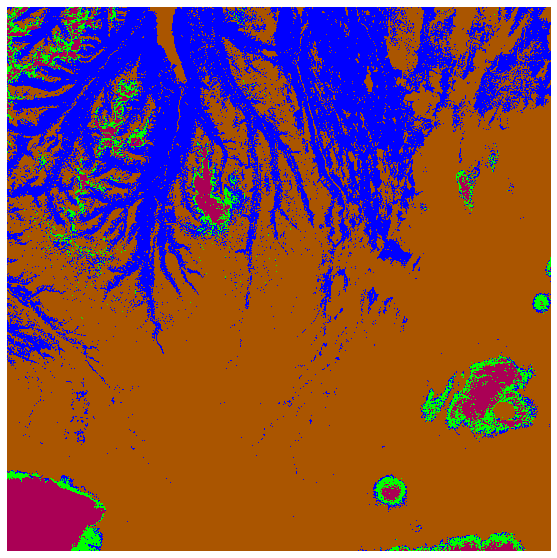

In [24]:
#Using all the bands with 3 classes
n_classes=4
data=createData(dataR60m,bands)
stack = data2stack(data)
kmeans = KMeans(n_clusters=n_classes).fit(stack)

label_arr = np.array(np.split(kmeans.labels_, data[0].width))

plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(label_arr, cmap='brg', interpolation='nearest')

In [ ]:
#Water and flood plain in orange, glacier in pink, rocks in green, tundra vegetaion in orange. A transform fault along the Mid-Adlantic Ridge is clearly visible due to delination of four class boundaries instead of three.





In [25]:
#Checking number of occurances
for i in range(n_classes):
  print('Label', i, ' : ',np.count_nonzero(kmeans.labels_ == i),  'occurences')

Label 0  :  813566 occurences
Label 1  :  133682 occurences
Label 2  :  2309308 occurences
Label 3  :  92344 occurences


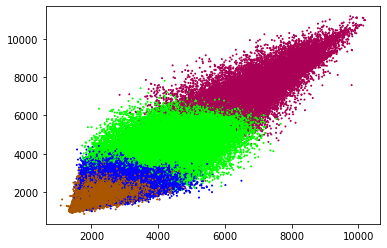

In [26]:
#Creating scatter plot for occurences
plt.scatter(stack.T[0], stack.T[1], c=kmeans.labels_, cmap='brg', s=1, alpha=1)

# Determination of optimum bands to use

In [29]:
#Let's determiine the optimal number of bands to use using the pearson correlation coefficient
from scipy import stats
data=dataR60m
array= []
for i in data.values():
  row = []
  for j in data.values():
    pearson_coeff = stats.pearsonr(i.read()[0].flatten(), j.read()[0].flatten())[0]
    pearson_coeff = round(ndigits=2, number=pearson_coeff)
    row.append(pearson_coeff)
    
  array.append(row)

df=pd.DataFrame(array, columns=data.keys(), index=data.keys())

In [30]:
#Now getting which bands to use
corr=df.corr()
cols=np.full((corr.shape[0],), True, dtype=bool)
for i in range(corr.shape[0]):
    for j in range(i+1,corr.shape[0]):
        if corr.iloc[i,j]>=0.5:
            if cols[j]:
                cols[j]=False
selected_cols=df.columns[cols]
data=df[selected_cols]
print(data)

       B01   B10   B11
B01   1.00  0.42 -0.27
B02   0.99  0.41 -0.26
B03   0.99  0.42 -0.23
B04   0.98  0.41 -0.23
B05   0.98  0.46 -0.14
B06   0.91  0.52  0.06
B07   0.87  0.54  0.13
B08A  0.81  0.56  0.22
B08   0.84  0.55  0.17
B09   0.86  0.63  0.17
B10   0.42  1.00  0.36
B11  -0.27  0.36  1.00
B12  -0.20  0.36  0.88
TCI   0.91  0.31 -0.22


As seen from the above dataframe that the bands that have the least correlation among them are B01, B10 and B11

# Running K-means for optimum number of clusters and optimum bands

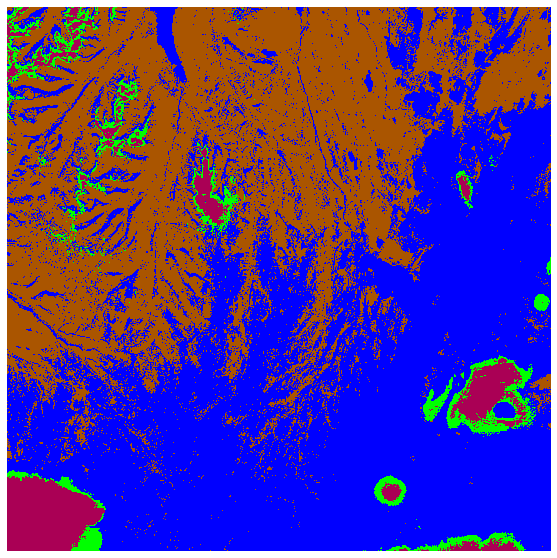

In [31]:
# From the above dataframe it can be seen that the bands that have the least correlation among them are B01, B10 and B11
band=['B01','B10','B11']
n_classes=4
data=createData(dataR60m,band)
stack = data2stack(data)
kmeans = KMeans(n_clusters=n_classes).fit(stack)

label_arr = np.array(np.split(kmeans.labels_, data[0].width))

plt.figure(figsize = (10,10))
plt.axis('off')
plt.imshow(label_arr, cmap='brg', interpolation='nearest')


In [ ]:
#In the above classified K-Means output, glaciers are seen in pink, rocks/sand in green, tundra vegetaion in orange. Blue is both water and flood plain it seems. Four classes appears not to be enough to distinguish from floodplain despite four bands being suggested by the elbow rule

In [32]:
#Checking number of occurances
for i in range(n_classes):
  print('Label', i, ' : ',np.count_nonzero(kmeans.labels_ == i),  'occurences')

Label 0  :  1777189 occurences
Label 1  :  138150 occurences
Label 2  :  1329332 occurences
Label 3  :  104229 occurences


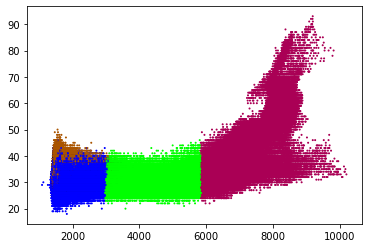

In [33]:
#Creating scatter plot for occurences
plt.scatter(stack.T[0], stack.T[1], c=kmeans.labels_, cmap='brg', s=1, alpha=1)

# Alternative Clustering Alorithms

I tried using other algorithms with full uncropped images. However, I ran into problems as they required too much disk space. 660GB is too much for a C drive to handle much less an partially full external hardrive. Instead, I focused on the Askja volcano and nearby rift valley before re-applying the algorithms. 

(654930.0, 7245090.0)


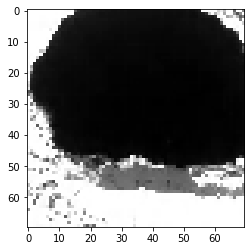

In [23]:
#first location of subset is defined
dataset=rasterio.open(ImgList[-1])
print(dataset.xy(dataset.height//2,dataset.width//2))
subset=(698000.0,7220000.0,70,70)
def crop_image(dataset, x, y, row, col):
  row_off,col_off = dataset.index(x,y)
  window = rasterio.windows.Window(col_off, row_off, row, col)
  return dataset.read(window=window).astype('float')[0]
     
plt.imshow(
  crop_image(dataset, *subset), cmap='gray')

Now the image is cropped, let's try Birch clustering.

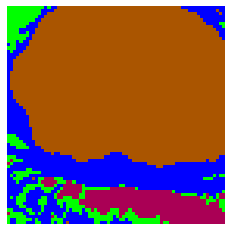

In [24]:
#Birch
band=['B01','B10','B11']
n_classes=4
data=createData(dataR60m,band)
stack = np.array([crop_image(i, *subset).flatten() for i in data]).T
birch = Birch(n_clusters=n_classes,
                  threshold=0.5).fit(stack)
label_array = np.array(np.split(birch.labels_, subset[3]))

plt.axis('off')
plt.imshow(label_array, cmap='brg', interpolation='nearest')

In [27]:
#Checking number of occurances
for i in range(n_classes):
  print('Label', i, ' : ',np.count_nonzero(birch.labels_ == i),  'occurences')

Label 0  :  1028 occurences
Label 1  :  424 occurences
Label 2  :  3058 occurences
Label 3  :  390 occurences


In [ ]:
#Heirachical clustering provided by Birch and Ward does appear to yield better results than K-Means which relies upon mimimum distance to mean, which is notoriously faulty

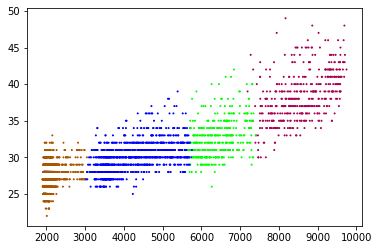

In [29]:
#Creating scatter plot for occurences
plt.scatter(stack.T[0], stack.T[1], c=birch.labels_, cmap='brg', s=1, alpha=1)

I also tried the Ward clustering techinique.

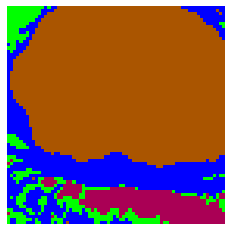

In [34]:
#Ward
band=['B01','B10','B11']
n_classes=4
data=createData(dataR60m,band)
stack = np.array([crop_image(i, *subset).flatten() for i in data]).T
ward = AgglomerativeClustering(n_clusters=n_classes).fit(stack)
label_array = np.array(np.split(ward.labels_, subset[3]))

plt.axis('off')
plt.imshow(label_array, cmap='brg', interpolation='nearest')

In [33]:
#Checking number of occurances
for i in range(n_classes):
  print('Label', i, ' : ',np.count_nonzero(ward.labels_ == i),  'occurences')

Label 0  :  1028 occurences
Label 1  :  424 occurences
Label 2  :  3058 occurences
Label 3  :  390 occurences


In [4]:
#Creating scatter plot for occurences
plt.scatter(stack.T[0], stack.T[1], c=ward.labels_, cmap='brg', s=1, alpha=1)

NameError: name 'stack' is not defined